In [1]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from collections import OrderedDict
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import time
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
geonames = pd.read_pickle("../../../../dosT/ffunes/geonames_parsed.pkl")

from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_distance(row):
    predicted_lat = row['predicted_lat']
    predicted_lon = row['predicted_lon']
    real_lat = row['real_lat']
    real_long = row['real_lon']
    
    return haversine_distance(predicted_lat, predicted_lon, real_lat, real_long)

def get_difference_distance(predicted_place, real_place):
    df_prediction = pd.DataFrame({
        'predicted_place': predicted_place,
        'real_place': real_place
    }, dtype=float)
        
    df_prediction[['predicted_cities','predicted_countries']] = df_prediction.predicted_place.str.split(',', expand=True) 
    df_prediction[['real_cities','real_countries']] = df_prediction.real_place.str.split(',', expand=True) 
    
    del df_prediction['predicted_place']
    del df_prediction['real_place']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['predicted_cities', 'predicted_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    df_prediction.rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'}, inplace=True)
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['real_cities', 'real_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction.rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'}, inplace=True)
    
    #print(df_prediction.head(5))
    
    print("Total NaN: ", df_prediction.shape[0]-df_prediction.dropna(subset=['real_lat', 'real_lon', 'predicted_lat', 'predicted_lon']).shape[0])

    return df_prediction.apply(determine_distance, axis=1)

In [3]:
tweets_with_mentions = pd.read_csv("../../../../dosT/ffunes/mentions_with_tweets_geonames.csv")
del tweets_with_mentions["Unnamed: 0"]

In [4]:
mention_count = tweets_with_mentions.loc[:,['user_id', 'user_mentioned']].\
    drop_duplicates().groupby('user_mentioned').count()

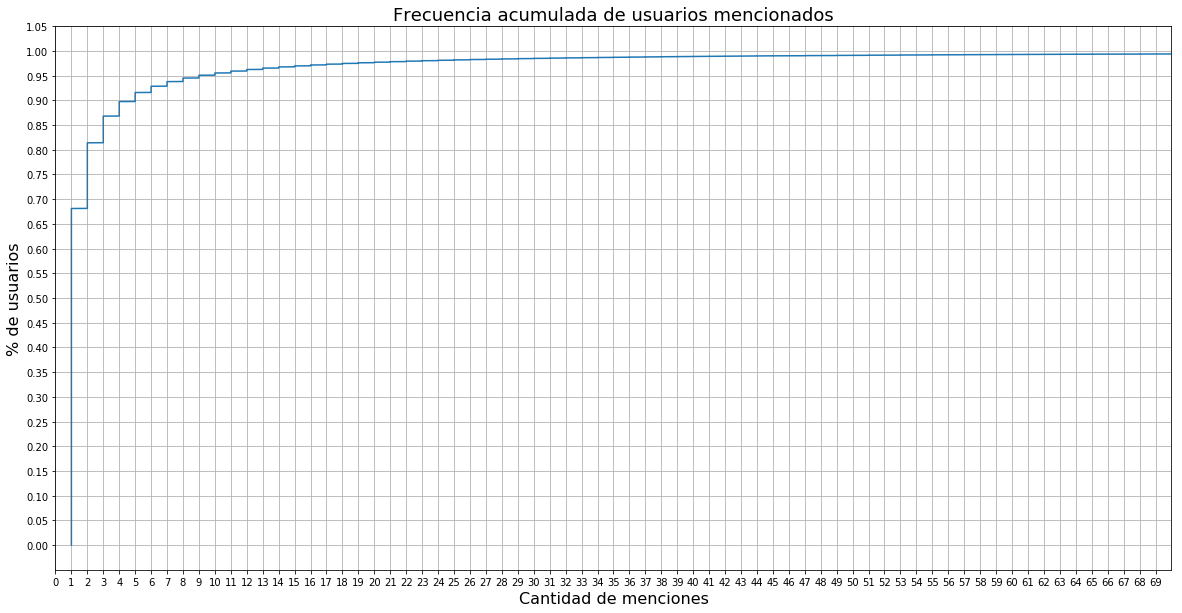

In [5]:
ecdf = ECDF(mention_count["user_id"])

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Cantidad de menciones", fontsize=16)
plt.ylabel("% de usuarios", fontsize=16)
plt.title("Frecuencia acumulada de usuarios mencionados", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.05))
plt.xticks(np.arange(0,70,1))
plt.xlim(0, 70)
#plt.hlines(accuracy_score(y_test[:, 0], y_predicted_city), -200, 1000, colors='r', linestyles='dashed')
#plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [8]:
usecols = [
    "id",
    "place_name",
    "place_country",
    "latitude",
    "longitude"
]

users = pd.read_pickle("../../../../dosT/ffunes/total_users_parsed.pkl")
users = users.loc[:, usecols]

print(users.shape)

users["unified_place"] = users["place_name"] + ',' + users["place_country"]

min_determined_place = users.loc[:, ["id", "unified_place"]].groupby("unified_place").count().sort_values('id', ascending=False).reset_index()

min_determined_place = min_determined_place.loc[min_determined_place["id"] >= 1170, :]

users = pd.merge(
    left=users,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)

del users["place_name"]
del users["place_country"]

TOTAL_USERS = users.shape[0]

(176029, 5)


In [7]:
TOTAL_USERS

80812

In [7]:
import re
def extract_oslom(filename):
    """Funcion que extrae las comunidades detectadas por OSLOM a las que pertence un vertice de la red."""
    clusters = {}
    hashtag_clusters = {}
    data = []
    with open(filename) as f:
        cluster = ""
        for line in f:
            m = re.search("^#module\s([0-9]+).*", line)
            #print line
            if (m is not None):
                cluster = int(m.group(1))
            else:
                l = line.replace('\n', ' ').strip().split(" ")
                l = list(map(int, l))
                clusters[cluster] = l
                for i in l:
                    if not i in hashtag_clusters:
                        hashtag_clusters[i] = set()
                    hashtag_clusters[i].add(cluster)
                    data.append([i, cluster])
    return pd.DataFrame(data=data, columns=["user_id", "cluster"]), hashtag_clusters

In [8]:
values_sample = np.unique(np.logspace(0, 4, num=40, dtype="int"))
values_sample

array([    1,     2,     3,     4,     5,     6,     8,    10,    13,
          17,    21,    27,    34,    43,    55,    70,    88,   112,
         142,   180,   228,   289,   366,   464,   587,   744,   942,
        1193,  1511,  1914,  2424,  3070,  3888,  4923,  6235,  7896,
       10000])

In [21]:
#Usar logistic regression

df_final = pd.DataFrame(columns=[
    "total_users", 
    "users_filtered",
    "users_to_train",
    "mean_accuracy_train",
    "mean_accuracy_test",
    "mean_balanced_accuracy_test",
    "mean_accuracy_100km",
    "mean_accuracy_161km",
    "max_accuracy_train",
    "max_accuracy_test",
    "max_balanced_accuracy_test",
    "max_accuracy_100km",
    "max_accuracy_161km",    
    "minimum_user_mentioned"
    ])
'''
df_final_single_cluster = pd.DataFrame(columns=[
    "total_users", 
    "users_filtered",
    "mean_accuracy_train",
    "mean_accuracy_test",
    "mean_balanced_accuracy_test",
    "mean_accuracy_100km",
    "mean_accuracy_161km",
    "max_accuracy_train",
    "max_accuracy_test",
    "max_balanced_accuracy_test",
    "max_accuracy_100km",
    "max_accuracy_161km",    
    "minimum_user_mentioned"
    ])'''

iteration = 0
start = time.time()
for min_mention in values_sample:
    print("Start iteration {}".format(iteration))

    count = mention_count.reset_index()
    
    lim_mentioned_users = count.loc[
        ((count["user_id"] >= min_mention)),
        ["user_mentioned"]
    ]
    
    tweets_with_mentions_limit = pd.merge(
        left=tweets_with_mentions,
        right=lim_mentioned_users,
        how='inner',
        left_on=["user_mentioned"],
        right_on=["user_mentioned"],
        validate="m:1" 
    )
    
    users_with_mentions = pd.merge(
        left=users,
        right=tweets_with_mentions_limit.loc[:, ["user_mentioned", "user_id"]],
        how='inner',
        left_on=["id"],
        right_on=["user_id"],
        validate="1:m" 
    )
    
    del users_with_mentions["id"]
    
    print("Users filtered")
    
    if users_with_mentions.shape[0] == 0:
        print("No more users")
        break
    
    users_with_mentions = users_with_mentions.groupby(
        ["user_id", "unified_place", "latitude", "longitude"]
    )['user_mentioned'].apply(list).reset_index(name='users_mentioned')
    
    USERS_FILTERED = users_with_mentions.shape[0]
    
    users_with_mentions["users_mentioned"] = users_with_mentions["users_mentioned"].apply(lambda l: list(map(str, l)))
    users_with_mentions["user_id"] = users_with_mentions["user_id"].apply(lambda l: str(l))
    
    users_with_mentions.loc[:, ['users_mentioned']] = users_with_mentions["users_mentioned"].apply(lambda l: list(map(str, l)))
        
    users_train_selected = users_with_mentions
        
    users_ids = users_train_selected["user_id"].apply(lambda l: str(l)).values
    
    a = set()
    
    for x in users_train_selected["users_mentioned"].values:
        for val in x:
            a.add(str(val))

    all_users_mentioned = list(a)
    
    total_users = np.concatenate([users_ids, all_users_mentioned])
    
    a = OrderedDict.fromkeys(total_users)
    
    total_users = list(a)
    
    vectorizer = CountVectorizer(
        strip_accents="ascii",
        lowercase=False,
        vocabulary=total_users,
        token_pattern=r"(?u)\b\w+\b"
    )

    vector_of_mentions = vectorizer.fit_transform(users_train_selected["users_mentioned"].apply(lambda x: ' '.join(x))).astype('int')
    
    print("Vector of mentions built")
    
    cx = vector_of_mentions.tocoo()
    edges = []
    checker = list(range(users_train_selected.shape[0]))

    for i,j,v in zip(cx.row, cx.col, cx.data):
        #format_str = users_ids[i] + " " + users_ids[j] + " " + str(v)
        format_str = str(i) + " " + str(j) + " " + str(v)
        edges.append(format_str)
        
    df = pd.DataFrame({"edges": edges})
    df.to_csv("../results/tmp/edges_mentions_weighted_test.csv", header=False, index=False)
    
    print("Edges stored in disk")
    print("Starting Oslom")
    
    scores_train = []
    scores_test = []
    balanced_scores = []
    scores_100km = []
    scores_161km = []
    
    scores_train_single_cluster = []
    scores_test_single_cluster = []
    balanced_scores_single_cluster = []
    scores_100km_single_cluster = []
    scores_161km_single_cluster = []
    
    for l in range(0, 1):
        !cd ../oslom/OSLOM2 && \
        ./oslom_dir -f ../../results/tmp/edges_mentions_weighted_test.csv -w -fast -seed 430430 -cp 0.5

        print("Oslom ended, starting predictions")

        '''exclude = [i for i, line in enumerate(open('../edges_mentions_weighted_test.clu')) if line.startswith('#')]
        communities_infomap = pd.read_csv("../edges_mentions_weighted_test.clu", names=["user_id", "k", "flow"], skiprows = exclude, sep=" ")
        del communities_infomap["flow"]'''
        
        train, clusters = extract_oslom('../results/tmp/edges_mentions_weighted_test.csv_oslo_files/tp')
        
        def get_original_user_id(row):
            return total_users[row["user_id"]]

        #communities_infomap["real_user_id"] = communities_infomap.apply(get_original_user_id, axis=1)
        train["real_user_id"] = train.apply(get_original_user_id, axis=1)
        train_single_cluster = train.copy()
        
        train_single_cluster.drop_duplicates(["real_user_id"], keep="first", inplace=True)

        train = train.astype({'real_user_id': 'int64'})
        
        users_train_final = pd.merge(
            left=train,
            #right=users_train_selected,
            right=users,
            how='inner',
            left_on="real_user_id",
            right_on="id",
            validate="m:1"
        )
        
        USERS_TOTAL_TRAIN = users_train_final.shape[0]
        
        users_train_final_single_cluster = pd.merge(
            left=train_single_cluster,
            right=users_train_selected,
            how='inner',
            left_on="real_user_id",
            right_on="user_id",
            validate="1:1"
        )
        
        users_train_final = users_train_final.loc[:, ["real_user_id", "cluster", "unified_place", "latitude", "longitude"]]
        
        users_train_final = users_train_final.groupby(
            ["real_user_id", "unified_place", "latitude", "longitude"]
        )['cluster'].apply(list).reset_index(name='clusters')
        
        users_train_final = users_train_final.sample(frac=1, random_state=4503493)
        users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
        class_names = sorted(users_train_final['unified_place'].unique())
        
        users_train_final_single_cluster = users_train_final_single_cluster.sample(frac=1, random_state=4503493)
        users_complete_location_single_cluster = users_train_final_single_cluster.loc[:, ["unified_place", "latitude", "longitude"]].values
        
        #users_train_final = users_train_final.loc[:, ["k"]]
        users_train_final = users_train_final.loc[:, ["clusters"]]
        users_train_final_single_cluster = users_train_final_single_cluster.loc[:, ["cluster"]]
        
        users_train_final["clusters"] = users_train_final["clusters"].apply(lambda l: list(map(str, l)))

        vectorizer = CountVectorizer(
            strip_accents="ascii",
            lowercase=False,
            token_pattern=r"(?u)\b\w+\b"
        )
        
        print(users_train_final.head())

        vector_of_clusters = vectorizer.fit_transform(users_train_final["clusters"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
        vector_of_clusters        
        
        print("Data prepared for training")
        
        #X_train, X_test, y_train, y_test = train_test_split(users_train_final, users_complete_location[:,0], test_size=0.30)

        #decisiontree = DecisionTreeClassifier()
        '''decisiontree = RandomForestClassifier(n_jobs=2)
        decisiontree.get_params()'''
        
        logistic = LogisticRegression(n_jobs=2, multi_class='multinomial')
        
        X_train, X_test, y_train, y_test = train_test_split(vector_of_clusters, users_complete_location[:,0], test_size=0.30)
        
        print("Starting train")

        #param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
        #         'class_weight': ['balanced']}
        
        param_grid={'C': [0.5, 1.0], 'class_weight': ['balanced']}
        
        grid_drop = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy')
        grid_drop.fit(X_train, y_train)

        #BEST_SCORE_TRAIN = grid_drop.best_score_
        scores_train.append(grid_drop.best_score_)
        
        y_predicted = grid_drop.predict(X_test)

        #BEST_SCORE_TEST = accuracy_score(y_test, y_predicted)
        
        scores_test.append(accuracy_score(y_test, y_predicted))

        #BALANCED_SCORE = balanced_accuracy_score(y_test, y_predicted)
        
        balanced_scores.append(balanced_accuracy_score(y_test, y_predicted))
        
        distances_predicted = get_difference_distance(
            y_predicted,
            y_test
        )

        #ACCURACY_100km = distances_predicted[distances_predicted <= 100].shape[0]/distances_predicted.shape[0]
        scores_100km.append(distances_predicted[distances_predicted <= 100].shape[0]/distances_predicted.shape[0])
        #ACCURACY_161km = distances_predicted[distances_predicted <= 161].shape[0]/distances_predicted.shape[0]
        scores_161km.append(distances_predicted[distances_predicted <= 161].shape[0]/distances_predicted.shape[0])

        '''X_train, X_test, y_train, y_test = train_test_split(users_train_final_single_cluster, users_complete_location_single_cluster[:,0], test_size=0.30)
        
        print("Starting second train")

        param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
                 'class_weight': ['balanced']}
        grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
        grid_drop.fit(X_train, y_train)

        #BEST_SCORE_TRAIN = grid_drop.best_score_
        scores_train_single_cluster.append(grid_drop.best_score_)
        
        y_predicted = grid_drop.predict(X_test)

        #BEST_SCORE_TEST = accuracy_score(y_test, y_predicted)
        
        scores_test_single_cluster.append(accuracy_score(y_test, y_predicted))

        #BALANCED_SCORE = balanced_accuracy_score(y_test, y_predicted)
        
        balanced_scores_single_cluster.append(balanced_accuracy_score(y_test, y_predicted))
        
        distances_predicted = get_difference_distance(
            y_predicted,
            y_test
        )

        #ACCURACY_100km = distances_predicted[distances_predicted <= 100].shape[0]/distances_predicted.shape[0]
        scores_100km_single_cluster.append(distances_predicted[distances_predicted <= 100].shape[0]/distances_predicted.shape[0])
        #ACCURACY_161km = distances_predicted[distances_predicted <= 161].shape[0]/distances_predicted.shape[0]
        scores_161km_single_cluster.append(distances_predicted[distances_predicted <= 161].shape[0]/distances_predicted.shape[0])
        '''
    MEAN_SCORE_TRAIN = np.mean(scores_train)
    MEAN_SCORE_TEST = np.mean(scores_test)
    MEAN_BALANCED_SCORE = np.mean(balanced_scores)
    MEAN_ACCURACY_100km = np.mean(scores_100km)
    MEAN_ACCURACY_161km = np.mean(scores_161km)
    
    MAX_SCORE_TRAIN = np.max(scores_train)
    MAX_SCORE_TEST = np.max(scores_test)
    MAX_BALANCED_SCORE = np.max(balanced_scores)
    MAX_ACCURACY_100km = np.max(scores_100km)
    MAX_ACCURACY_161km = np.max(scores_161km)
    
    df_final.loc[iteration] = [
        TOTAL_USERS,
        USERS_FILTERED,
        USERS_TOTAL_TRAIN,
        MEAN_SCORE_TRAIN,
        MEAN_SCORE_TEST,
        MEAN_BALANCED_SCORE,
        MEAN_ACCURACY_100km,
        MEAN_ACCURACY_161km,
        MAX_SCORE_TRAIN,
        MAX_SCORE_TEST,
        MAX_BALANCED_SCORE,
        MAX_ACCURACY_100km,
        MAX_ACCURACY_161km,
        min_mention
    ]
    
    '''MEAN_SCORE_TRAIN = np.mean(scores_train_single_cluster)
    MEAN_SCORE_TEST = np.mean(scores_test_single_cluster)
    MEAN_BALANCED_SCORE = np.mean(balanced_scores_single_cluster)
    MEAN_ACCURACY_100km = np.mean(scores_100km_single_cluster)
    MEAN_ACCURACY_161km = np.mean(scores_161km_single_cluster)
    
    MAX_SCORE_TRAIN = np.max(scores_train_single_cluster)
    MAX_SCORE_TEST = np.max(scores_test_single_cluster)
    MAX_BALANCED_SCORE = np.max(balanced_scores_single_cluster)
    MAX_ACCURACY_100km = np.max(scores_100km_single_cluster)
    MAX_ACCURACY_161km = np.max(scores_161km_single_cluster)
    
    df_final_single_cluster.loc[iteration] = [
        TOTAL_USERS,
        USERS_FILTERED,
        MEAN_SCORE_TRAIN,
        MEAN_SCORE_TEST,
        MEAN_BALANCED_SCORE,
        MEAN_ACCURACY_100km,
        MEAN_ACCURACY_161km,
        MAX_SCORE_TRAIN,
        MAX_SCORE_TEST,
        MAX_BALANCED_SCORE,
        MAX_ACCURACY_100km,
        MAX_ACCURACY_161km,
        min_mention
    ]'''
    
    iteration += 1
    
    print("Iteration end")
    print("--------------------------")
    df_final.to_csv("../results/tmp/results_test_mentions_min_oslom_tmp.csv", index=False)
    #df_final_single_cluster.to_csv("../results_test_mentions_max_single_cluster_oslom_tmp.csv", index=False) 
    
df_final.to_csv("../results/mentions/results_test_min_mentions_oslom_logistic_regressor_all_users.csv", index=False)
#df_final_single_cluster.to_csv("../results_test_mentions_max_single_cluster_oslom.csv", index=False)

end = time.time()

Start iteration 0
Users filtered
Vector of mentions built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_mentions_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 2314533 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 612506 nodes and 2.31453e+06 stubs;	 average degree = 3.77879
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 45693
iteration: 20 number of modules: 27678
collection done 


checked 0 modules 0 were 

checked 6800 modules 5743 were found significant.  Modules to check: 21565. Percentage nodes done: 0.691446
checked 6900 modules 5833 were found significant.  Modules to check: 21465. Percentage nodes done: 0.694039
checked 7000 modules 5912 were found significant.  Modules to check: 21365. Percentage nodes done: 0.696734
checked 7100 modules 5991 were found significant.  Modules to check: 21265. Percentage nodes done: 0.698614
checked 7200 modules 6068 were found significant.  Modules to check: 21165. Percentage nodes done: 0.700932
checked 7300 modules 6144 were found significant.  Modules to check: 21065. Percentage nodes done: 0.70326
checked 7400 modules 6218 were found significant.  Modules to check: 20965. Percentage nodes done: 0.705413
checked 7500 modules 6296 were found significant.  Modules to check: 20865. Percentage nodes done: 0.707815
checked 7600 modules 6373 were found significant.  Modules to check: 20765. Percentage nodes done: 0.710009
checked 7700 modules 6453 wer

checked 14400 modules 11066 were found significant.  Modules to check: 13965. Percentage nodes done: 0.847195
checked 14500 modules 11132 were found significant.  Modules to check: 13865. Percentage nodes done: 0.848976
checked 14600 modules 11195 were found significant.  Modules to check: 13765. Percentage nodes done: 0.850495
checked 14700 modules 11260 were found significant.  Modules to check: 13665. Percentage nodes done: 0.85189
checked 14800 modules 11318 were found significant.  Modules to check: 13565. Percentage nodes done: 0.85318
checked 14900 modules 11381 were found significant.  Modules to check: 13465. Percentage nodes done: 0.854403
checked 15000 modules 11428 were found significant.  Modules to check: 13365. Percentage nodes done: 0.855569
checked 15100 modules 11485 were found significant.  Modules to check: 13265. Percentage nodes done: 0.85734
checked 15200 modules 11551 were found significant.  Modules to check: 13165. Percentage nodes done: 0.858664
checked 15300

checked 21900 modules 14848 were found significant.  Modules to check: 6465. Percentage nodes done: 0.943617
checked 22000 modules 14888 were found significant.  Modules to check: 6365. Percentage nodes done: 0.94469
checked 22100 modules 14925 were found significant.  Modules to check: 6265. Percentage nodes done: 0.945774
checked 22200 modules 14962 were found significant.  Modules to check: 6165. Percentage nodes done: 0.946719
checked 22300 modules 15006 were found significant.  Modules to check: 6065. Percentage nodes done: 0.948041
checked 22400 modules 15044 were found significant.  Modules to check: 5965. Percentage nodes done: 0.948995
checked 22500 modules 15084 were found significant.  Modules to check: 5865. Percentage nodes done: 0.950045
checked 22600 modules 15121 were found significant.  Modules to check: 5765. Percentage nodes done: 0.951021
checked 22700 modules 15152 were found significant.  Modules to check: 5665. Percentage nodes done: 0.951885
checked 22800 module

checked 1100 unions. Fused: 0
checked 1200 unions. Fused: 0
checked 1300 unions. Fused: 0
checked 1400 unions. Fused: 0
checked 1500 unions. Fused: 0
checked 1600 unions. Fused: 0
checked 1700 unions. Fused: 0
checked 1800 unions. Fused: 0
checked 1900 unions. Fused: 0
checked 2000 unions. Fused: 0
checked 2100 unions. Fused: 0
checked 2200 unions. Fused: 0
checked 2400 unions. Fused: 0
checked 2500 unions. Fused: 0
checked 2600 unions. Fused: 0
checked 2700 unions. Fused: 0
checked 2900 unions. Fused: 0
checked 3100 unions. Fused: 0
checked 3200 unions. Fused: 0
checked 3700 unions. Fused: 0
checked 4000 unions. Fused: 0
checked 4100 unions. Fused: 0
checked 4200 unions. Fused: 0
checked 4300 unions. Fused: 0
checked 4400 unions. Fused: 0
checked 4600 unions. Fused: 0
checked 4700 unions. Fused: 0
checked 4800 unions. Fused: 0
checked 4900 unions. Fused: 0
checked 5000 unions. Fused: 0
checked 5100 unions. Fused: 0
checked 5700 unions. Fused: 0
checked 6900 unions. Fused: 0
checked 70

checked 500 modules 219 were found significant.  Modules to check: 3500. Percentage nodes done: 0.223858
checked 600 modules 221 were found significant.  Modules to check: 3400. Percentage nodes done: 0.244691
checked 700 modules 222 were found significant.  Modules to check: 3300. Percentage nodes done: 0.264077
checked 800 modules 223 were found significant.  Modules to check: 3200. Percentage nodes done: 0.284749
checked 900 modules 228 were found significant.  Modules to check: 3100. Percentage nodes done: 0.304939
checked 1000 modules 234 were found significant.  Modules to check: 3000. Percentage nodes done: 0.327461
checked 1100 modules 237 were found significant.  Modules to check: 2900. Percentage nodes done: 0.347812
checked 1200 modules 240 were found significant.  Modules to check: 2800. Percentage nodes done: 0.371461
checked 1300 modules 246 were found significant.  Modules to check: 2700. Percentage nodes done: 0.393983
checked 1400 modules 250 were found significant.  M

checked 100 modules 36 were found significant.  Modules to check: 3698. Percentage nodes done: 0.0338831
checked 200 modules 66 were found significant.  Modules to check: 3598. Percentage nodes done: 0.0660771
checked 300 modules 157 were found significant.  Modules to check: 3498. Percentage nodes done: 0.0937997
checked 400 modules 257 were found significant.  Modules to check: 3398. Percentage nodes done: 0.119932
checked 500 modules 357 were found significant.  Modules to check: 3298. Percentage nodes done: 0.145469
checked 600 modules 456 were found significant.  Modules to check: 3198. Percentage nodes done: 0.170707
checked 700 modules 556 were found significant.  Modules to check: 3098. Percentage nodes done: 0.193859
checked 800 modules 656 were found significant.  Modules to check: 2998. Percentage nodes done: 0.220091
checked 900 modules 756 were found significant.  Modules to check: 2898. Percentage nodes done: 0.243641
checked 1000 modules 854 were found significant.  Modu

checked 2600 modules 4 were found significant.  Modules to check: 1184. Percentage nodes done: 0.647475
checked 2700 modules 4 were found significant.  Modules to check: 1084. Percentage nodes done: 0.671871
checked 2800 modules 4 were found significant.  Modules to check: 984. Percentage nodes done: 0.696267
checked 2900 modules 4 were found significant.  Modules to check: 884. Percentage nodes done: 0.720664
checked 3000 modules 4 were found significant.  Modules to check: 784. Percentage nodes done: 0.74506
checked 3100 modules 4 were found significant.  Modules to check: 684. Percentage nodes done: 0.769456
checked 3200 modules 4 were found significant.  Modules to check: 584. Percentage nodes done: 0.793852
checked 3300 modules 5 were found significant.  Modules to check: 484. Percentage nodes done: 0.820688
checked 3400 modules 5 were found significant.  Modules to check: 384. Percentage nodes done: 0.845084
checked 3500 modules 5 were found significant.  Modules to check: 284. P

allocating 2008841 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 310473 nodes and 2.00884e+06 stubs;	 average degree = 6.47026
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 33974
iteration: 20 number of modules: 11212
collection done 


checked 0 modules 0 were found significant.  Modules to check: 11709. Percentage nodes done: 0
checked 100 modules 95 were found significant.  Modules to check: 11609. Percentage nodes done: 0.460752
checked 200 modules 187 were found significant.  Modules to check: 11509. Percentage nodes done: 0.528355
checked 300 modules 281 were found significant.  Modules to check: 11409. Percentage nodes done: 0.570339
checked 400 modules 378 were found significant.  Modules to che

checked 7200 modules 6181 were found significant.  Modules to check: 4509. Percentage nodes done: 0.934696
checked 7300 modules 6253 were found significant.  Modules to check: 4409. Percentage nodes done: 0.93661
checked 7400 modules 6326 were found significant.  Modules to check: 4309. Percentage nodes done: 0.938619
checked 7500 modules 6401 were found significant.  Modules to check: 4209. Percentage nodes done: 0.940426
checked 7600 modules 6470 were found significant.  Modules to check: 4109. Percentage nodes done: 0.942343
checked 7700 modules 6541 were found significant.  Modules to check: 4009. Percentage nodes done: 0.94424
checked 7800 modules 6613 were found significant.  Modules to check: 3909. Percentage nodes done: 0.946176
checked 7900 modules 6683 were found significant.  Modules to check: 3809. Percentage nodes done: 0.948066
checked 8000 modules 6754 were found significant.  Modules to check: 3709. Percentage nodes done: 0.950334
checked 8100 modules 6823 were found si

checked 14000 unions. Fused: 5
checked 14100 unions. Fused: 5
checked 14900 unions. Fused: 5
checked 15400 unions. Fused: 5
checked 15900 unions. Fused: 5
checked 16000 unions. Fused: 5
checked 16100 unions. Fused: 5
checked 16400 unions. Fused: 5
checked 16600 unions. Fused: 5
checked 16700 unions. Fused: 5
checked 17200 unions. Fused: 5
checked 17300 unions. Fused: 5
checked 18400 unions. Fused: 5
checked 19900 unions. Fused: 5
check unions of modules using community network

iteration: 0 number of modules: 27706
iteration: 20 number of modules: 19932
collection done 


possible fusions to check: 19976
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 0
checked 700 unions. Fused: 1
checked 800 unions. Fused: 1
checked 900 unions. Fused: 2
checked 1000 unions. Fused: 2
checked 1100 unions. Fused: 2
checked 1200 unions. Fused: 3
checked 13

checked 500 modules 6 were found significant.  Modules to check: 93. Percentage nodes done: 0.678528
significance check done 


checking unions of not significant modules, modules to check: 571
iteration: 0 number of modules: 571
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 9 modules to check, run: 0
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 592
collection done 


possible fusions to check: 573
checked 0 unions. Fused: 1
check unions of modules using community network

iteration: 0 number of modules: 581
collection done 


possible fusions to check: 578
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
**************************************

checked 3100 modules 2837 were found significant.  Modules to check: 2886. Percentage nodes done: 0.935459
checked 3200 modules 2923 were found significant.  Modules to check: 2786. Percentage nodes done: 0.939991
checked 3300 modules 3001 were found significant.  Modules to check: 2686. Percentage nodes done: 0.943332
checked 3400 modules 3085 were found significant.  Modules to check: 2586. Percentage nodes done: 0.946385
checked 3500 modules 3166 were found significant.  Modules to check: 2486. Percentage nodes done: 0.949607
checked 3600 modules 3246 were found significant.  Modules to check: 2386. Percentage nodes done: 0.952738
checked 3700 modules 3332 were found significant.  Modules to check: 2286. Percentage nodes done: 0.955709
checked 3800 modules 3412 were found significant.  Modules to check: 2186. Percentage nodes done: 0.958351
checked 3900 modules 3491 were found significant.  Modules to check: 2086. Percentage nodes done: 0.960843
checked 4000 modules 3563 were found 

checked 100 modules 100 were found significant.  Modules to check: 217. Percentage nodes done: 0.698673
checked 200 modules 200 were found significant.  Modules to check: 117. Percentage nodes done: 0.838913
checked 300 modules 300 were found significant.  Modules to check: 17. Percentage nodes done: 0.97789
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 251 modules to check, run: 0
minimality check: 8 modules to check, run: 1
minimality check: 8 modules to check, run: 2
minimality check: 6 modules to check, run: 3
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 324
iteration: 20 number of modules: 260
collection done 


possible fusions to check: 259
checked 0 unions. Fus

checked 1400 modules 1330 were found significant.  Modules to check: 2318. Percentage nodes done: 0.913347
checked 1500 modules 1423 were found significant.  Modules to check: 2218. Percentage nodes done: 0.919988
checked 1600 modules 1518 were found significant.  Modules to check: 2118. Percentage nodes done: 0.92613
checked 1700 modules 1608 were found significant.  Modules to check: 2018. Percentage nodes done: 0.932901
checked 1800 modules 1701 were found significant.  Modules to check: 1918. Percentage nodes done: 0.938504
checked 1900 modules 1788 were found significant.  Modules to check: 1818. Percentage nodes done: 0.944714
checked 2000 modules 1877 were found significant.  Modules to check: 1718. Percentage nodes done: 0.948785
checked 2100 modules 1963 were found significant.  Modules to check: 1618. Percentage nodes done: 0.954195
checked 2200 modules 2047 were found significant.  Modules to check: 1518. Percentage nodes done: 0.958755
checked 2300 modules 2133 were found s

writing final solution in file ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files/short_tp1
******** module_collection ******** 156 modules. writing... 
DONE   ****************************
network:: 255 nodes and 745203 stubs;	 average degree = 2922.36
STARTING! HIERARCHICAL LEVEL: 2
***************************************************************** RUN: #1
iteration: 0 number of modules: 148
collection done 


checked 0 modules 0 were found significant.  Modules to check: 127. Percentage nodes done: 0
checked 100 modules 4 were found significant.  Modules to check: 27. Percentage nodes done: 0.517647
significance check done 


checking unions of not significant modules, modules to check: 112
iteration: 0 number of modules: 112
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 6 modules to check, run: 0
************************

minimality check: 935 modules to check, run: 0
minimality check: 22 modules to check, run: 1
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 8129
iteration: 20 number of modules: 4215
collection done 


possible fusions to check: 4241
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 1
checked 500 unions. Fused: 1
checked 600 unions. Fused: 1
checked 700 unions. Fused: 1
checked 800 unions. Fused: 1
checked 1100 unions. Fused: 3
checked 1200 unions. Fused: 3
checked 1300 unions. Fused: 3
checked 1400 unions. Fused: 3
checked 1500 unions. Fused: 3
checked 1600 unions. Fused: 3
checked 1700 unions. Fused: 3
checked 1800 unions. Fused: 4
checked 1900 unions. Fused: 5
checked 2000 unions. Fused: 5
checked 2100 unions. Fused: 5
checked 2200 unions

network:: 123 nodes and 180781 stubs;	 average degree = 1469.76
STARTING! HIERARCHICAL LEVEL: 4
***************************************************************** RUN: #1
iteration: 0 number of modules: 83
collection done 


checked 0 modules 0 were found significant.  Modules to check: 78. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 69
iteration: 0 number of modules: 69
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 71
collection done 


possible fusions to check: 70
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
**********************************

iteration: 0 number of modules: 175
iteration: 20 number of modules: 118
collection done 


checked 0 modules 0 were found significant.  Modules to check: 118. Percentage nodes done: 0
checked 100 modules 100 were found significant.  Modules to check: 18. Percentage nodes done: 0.938744
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 73 modules to check, run: 0
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 129
iteration: 20 number of modules: 85
collection done 


possible fusions to check: 84
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 101
iteration: 20 number of modules: 72
collection done 


possible fusio

minimality check: 9 modules to check, run: 1
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 4731
iteration: 20 number of modules: 2678
collection done 


possible fusions to check: 2693
checked 0 unions. Fused: 0
checked 100 unions. Fused: 1
checked 200 unions. Fused: 2
checked 300 unions. Fused: 3
checked 400 unions. Fused: 3
checked 500 unions. Fused: 3
checked 600 unions. Fused: 3
checked 700 unions. Fused: 3
checked 800 unions. Fused: 3
checked 900 unions. Fused: 3
checked 1200 unions. Fused: 3
checked 1700 unions. Fused: 3
checked 2400 unions. Fused: 3
check unions of modules using community network

iteration: 0 number of modules: 4699
iteration: 20 number of modules: 2727
collection done 


possible fusions to check: 2781
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 1
checked 300 unions

iteration: 0 number of modules: 15102
iteration: 20 number of modules: 1485
iteration: 40 number of modules: 1349
collection done 


checked 0 modules 0 were found significant.  Modules to check: 1381. Percentage nodes done: 0
checked 100 modules 87 were found significant.  Modules to check: 1281. Percentage nodes done: 0.732965
checked 200 modules 176 were found significant.  Modules to check: 1181. Percentage nodes done: 0.852909
checked 300 modules 274 were found significant.  Modules to check: 1081. Percentage nodes done: 0.901669
checked 400 modules 371 were found significant.  Modules to check: 981. Percentage nodes done: 0.924853
checked 500 modules 470 were found significant.  Modules to check: 881. Percentage nodes done: 0.943037
checked 600 modules 568 were found significant.  Modules to check: 781. Percentage nodes done: 0.95372
checked 700 modules 661 were found significant.  Modules to check: 681. Percentage nodes done: 0.96301
checked 800 modules 753 were found significan

Oslom ended, starting predictions
      clusters
23680    [234]
39656    [378]
34576    [377]
41649    [234]
6632     [234]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 8
Users filtered
Vector of mentions built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_mentions_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 1438187 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 89394 nodes and 1.43819e+06 stubs;	 average degree = 16.0882
STARTIN

network:: 28 nodes and 759 stubs;	 average degree = 27.1071
STARTING! HIERARCHICAL LEVEL: 4
***************************************************************** RUN: #1
iteration: 0 number of modules: 20
collection done 


checked 0 modules 0 were found significant.  Modules to check: 19. Percentage nodes done: 0
significance check done 


checking unions of not significant modules, modules to check: 19
iteration: 0 number of modules: 18
collection done 


checking unions of not significant modules, modules to check: 1
iteration: 0 number of modules: 1
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
pruning all the modules collected. Partitions fou

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 12
collection done 


possible fusions to check: 12
checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 11
collection done 


possible fusions to check: 11
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 1
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 3 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files/partitions_level_2
3 groups found
3 bss found
checking homeless nodes
writing final solution in file ../../results/tmp/edges_mentions_weighted

assigning homeless nodes. Homeless at this point: 13
writing final solution in file ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files/tp
******** module_collection ******** 244 modules. writing... 
DONE   ****************************
network:: 257 nodes and 589804 stubs;	 average degree = 2294.96
STARTING! HIERARCHICAL LEVEL: 1
***************************************************************** RUN: #1
iteration: 0 number of modules: 64
collection done 


checked 0 modules 0 were found significant.  Modules to check: 31. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 11 modules to check, run: 0
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modul

checked 500 unions. Fused: 3
checked 600 unions. Fused: 3
check unions of modules using community network

iteration: 0 number of modules: 2565
iteration: 20 number of modules: 2039
collection done 


possible fusions to check: 2044
checked 0 unions. Fused: 0
checked 100 unions. Fused: 1
checked 200 unions. Fused: 1
checked 300 unions. Fused: 1
checked 400 unions. Fused: 1
checked 500 unions. Fused: 1
checking highly intersecting modules

pairs to check: 611
pairs to check: 24
pairs to check: 15
pairs to check: 10
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 236 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files/partitions_level_0
236 groups found
236 bss found
checking homeless nodes
assigning homeless nodes. Homeless at this poi

allocating 1145896 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 63078 nodes and 1.1459e+06 stubs;	 average degree = 18.1663
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 7791
iteration: 20 number of modules: 883
collection done 


checked 0 modules 0 were found significant.  Modules to check: 893. Percentage nodes done: 0
checked 100 modules 99 were found significant.  Modules to check: 793. Percentage nodes done: 0.803561
checked 200 modules 198 were found significant.  Modules to check: 693. Percentage nodes done: 0.854101
checked 300 modules 298 were found significant.  Modules to check: 593. Percentage nodes done: 0.901313
checked 400 modules 398 were found significant.  Modules to check: 493. Perc

Oslom ended, starting predictions
      clusters
10256    [162]
30446    [184]
24759      [2]
3829     [150]
41006    [169]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 13
Users filtered
Vector of mentions built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_mentions_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 1073118 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 59255 nodes and 1.07312e+06 stubs;	 average degree = 18.1102
STARTI

Oslom ended, starting predictions
      clusters
29811    [136]
988       [45]
44754    [131]
25078    [130]
9012     [179]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 14
Users filtered
Vector of mentions built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_mentions_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 993082 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 55699 nodes and 993082 stubs;	 average degree = 17.8294
STARTING! HI

Oslom ended, starting predictions
      clusters
9530     [141]
43733    [105]
42224    [132]
28584     [46]
21920    [119]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 15
Users filtered
Vector of mentions built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_mentions_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 917617 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 52782 nodes and 917617 stubs;	 average degree = 17.385
STARTING! HIE

Oslom ended, starting predictions
      clusters
18415     [91]
25007     [88]
7764      [91]
44841    [133]
29341    [126]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 16
Users filtered
Vector of mentions built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_mentions_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 841958 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 50283 nodes and 841958 stubs;	 average degree = 16.7444
STARTING! HI

Oslom ended, starting predictions
      clusters
17558     [87]
8275      [95]
40493     [46]
22822     [95]
40712     [78]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 17
Users filtered
Vector of mentions built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_mentions_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 763921 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 47815 nodes and 763921 stubs;	 average degree = 15.9766
STARTING! HI

minimality check: 111 modules to check, run: 0
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 1663
iteration: 20 number of modules: 1580
collection done 


possible fusions to check: 1762
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checking highly intersecting modules

pairs to check: 176
pairs to check: 60
pairs to check: 22
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 83 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files/partitions_level_0
83 groups found
83 bss found
checking homeless nodes
assigning hom

checked 0 unions. Fused: 0
check unions of modules using community network

iteration: 0 number of modules: 10
collection done 


possible fusions to check: 3
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 3
pairs to check: 2
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 7 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files/partitions_level_1
7 groups found
7 bss found
checking homeless nodes
writing final solution in file ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files/short_tp1
******** module_collection ******** 8 modules. writing... 
DONE   ****************************
network:: 14 nodes and 164533 stubs;	 average degree = 11752.4
STARTING! HIERARCHICAL LEVEL: 2
*******************

Oslom ended, starting predictions
      clusters
29153     [70]
10329     [87]
11572     [78]
27229     [78]
18539      [3]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 21
Users filtered
Vector of mentions built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_mentions_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 475875 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 39656 nodes and 475875 stubs;	 average degree = 12.0001
STARTING! HI

assigning homeless nodes. Homeless at this point: 1681
writing final solution in file ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files/tp
******** module_collection ******** 66 modules. writing... 
DONE   ****************************
network:: 66 nodes and 222713 stubs;	 average degree = 3374.44
STARTING! HIERARCHICAL LEVEL: 1
***************************************************************** RUN: #1
iteration: 0 number of modules: 12
collection done 


checked 0 modules 0 were found significant.  Modules to check: 9. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 6
collection done 


possible fusions to ch

Oslom ended, starting predictions
      clusters
26308     [52]
34642     [39]
24936     [44]
5322      [46]
11859     [44]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 24
Users filtered
Vector of mentions built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_mentions_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 299191 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 33958 nodes and 299191 stubs;	 average degree = 8.81062
STARTING! HI

iteration: 0 number of modules: 266
collection done 


checked 0 modules 0 were found significant.  Modules to check: 206. Percentage nodes done: 0
checked 100 modules 100 were found significant.  Modules to check: 106. Percentage nodes done: 0.678791
checked 200 modules 200 were found significant.  Modules to check: 6. Percentage nodes done: 0.994678
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 105 modules to check, run: 0
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 3179
collection done 


possible fusions to check: 3116
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 197
**************************************************************

Oslom ended, starting predictions
      clusters
7772      [38]
26319     [45]
8100      [26]
5766      [35]
26629     [45]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 27
Users filtered
Vector of mentions built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_mentions_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 169695 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 28993 nodes and 169695 stubs;	 average degree = 5.85296
STARTING! HI

iteration: 0 number of modules: 12
collection done 


checked 0 modules 0 were found significant.  Modules to check: 8. Percentage nodes done: 0
significance check done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 4
collection done 


possible fusions to check: 2
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 1
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 3 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/tmp/edges_mentio

iteration: 0 number of modules: 2287
collection done 


possible fusions to check: 2271
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 33
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 21 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files/partitions_level_0
21 groups found
21 bss found
checking homeless nodes
assigning homeless nodes. Homeless at this point: 22622
assigning homeless nodes. Homeless at this point: 955
writing final solution in file ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files/tp
******** module_collection ******** 21 modules. writing... 
DONE   ****************************
network:: 21 nodes and 66596 stubs;	 average degree = 3171.24
STARTING! HIERARCHICAL LEVEL: 1
*

Total NaN:  0
Iteration end
--------------------------
Start iteration 32
Users filtered
Vector of mentions built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_mentions_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 48103 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 18372 nodes and 48103 stubs;	 average degree = 2.61828
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 13
collection done 


checked 0 modules 0 

Oslom ended, starting predictions
      clusters
5411       [1]
6169       [3]
11895      [3]
3300       [1]
6880       [2]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------
Start iteration 34
Users filtered
Vector of mentions built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/tmp/edges_mentions_weighted_test.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 24909 factorials...
done
mkdir: cannot create directory ‘../../results/tmp/edges_mentions_weighted_test.csv_oslo_files’: File exists
output files will be written in directory: ../../results/tmp/edges_mentions_weighted_test.csv_oslo_files
network:: 13604 nodes and 24909 stubs;	 average degree = 1.83101
STARTING! HIER

DONE   ****************************
hierarchies done ********* 
Oslom ended, starting predictions
     clusters
1992   [1993]
3088   [3089]
6328   [6329]
8259   [8260]
4647   [4648]
Data prepared for training
Starting train
Total NaN:  0
Iteration end
--------------------------


In [11]:
print((end - start)/60/60)

6.604020208650166


----------------------------------------

In [9]:
df_final = pd.read_csv("../results/mentions/results_test_min_mentions_oslom_logistic_regressor_all_users.csv")
df_final.head()

,total_users,users_filtered,users_to_train,mean_accuracy_train,mean_accuracy_test,mean_balanced_accuracy_test,mean_accuracy_100km,mean_accuracy_161km,max_accuracy_train,max_accuracy_test,max_balanced_accuracy_test,max_accuracy_100km,max_accuracy_161km,minimum_user_mentioned
0,80812.0,61053.0,67082.0,0.302127,0.300766,0.390015,0.576439,0.576439,0.302127,0.300766,0.390015,0.576439,0.576439,1.0
1,80812.0,57027.0,61864.0,0.312454,0.317693,0.405230,0.601020,0.601020,0.312454,0.317693,0.405230,0.601020,0.601020,2.0
2,80812.0,55237.0,58921.0,0.310519,0.313247,0.400673,0.600902,0.600902,0.310519,0.313247,0.400673,0.600902,0.600902,3.0
3,80812.0,54211.0,57281.0,0.297559,0.294580,0.386706,0.603325,0.603325,0.297559,0.294580,0.386706,0.603325,0.603325,4.0
4,80812.0,53562.0,56091.0,0.283828,0.295833,0.389098,0.625526,0.625526,0.283828,0.295833,0.389098,0.625526,0.625526,5.0


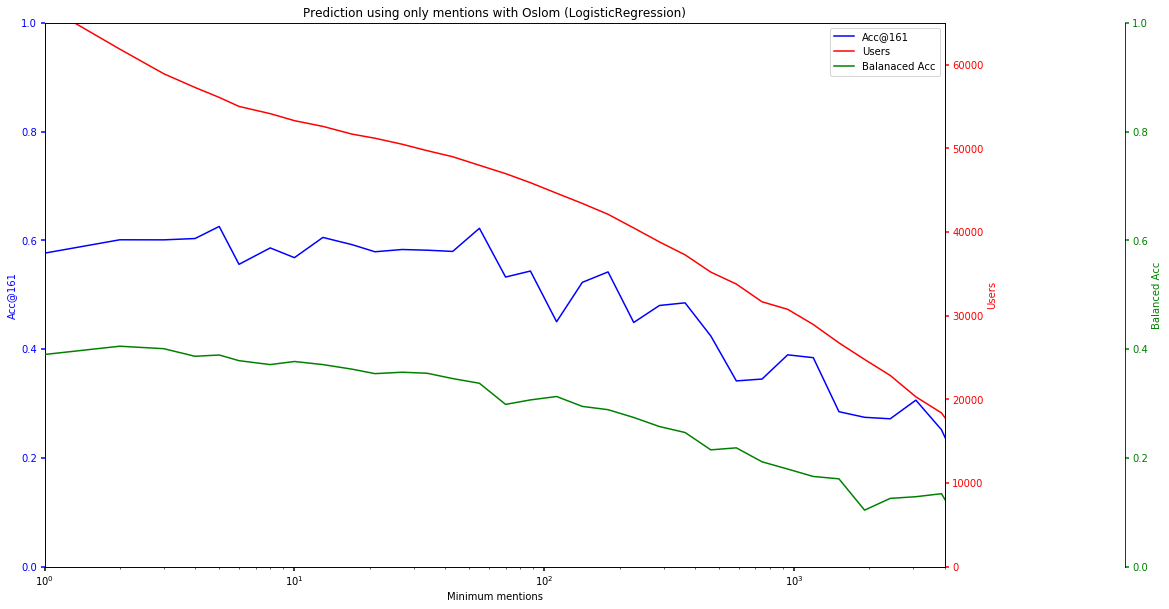

In [10]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
fig, host = plt.subplots(figsize=(20,10))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(df_final["minimum_user_mentioned"].values, df_final["mean_accuracy_161km"].values, "b-", label="Acc@161")
#p2, = par1.plot(df_final["minimum_user_mentioned"].values, df_final["users_filtered"].values, "r-", label="Users")
p2, = par1.plot(df_final["minimum_user_mentioned"].values, df_final["users_to_train"].values, "r-", label="Users")
p3, = par2.plot(df_final["minimum_user_mentioned"].values, df_final["mean_balanced_accuracy_test"].values, "g-", label="Balanaced Acc")

host.set_xscale('log')

host.set_xlim(1, 4000)
host.set_ylim(0, 1.0)
par1.set_ylim(0, 65000)
par2.set_ylim(0, 1.0)

host.set_xlabel("Minimum mentions")
host.set_ylabel("Acc@161")
par1.set_ylabel("Users")
par2.set_ylabel("Balanced Acc")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines])

plt.title("Prediction using only mentions with Oslom (LogisticRegression)")
plt.show()